In [1]:
from UtilDatasetPrepFromLORE import *
from Rankers import *
from PreferentialSampling import *
from UniformSampling import *
from StandardEval import *
from FairnessEval import *
from Explainers import *

21-Dec-21 16:54:18 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


# COMPAS

## Uniform Sampling

In [2]:
filename = 'compas-scores-two-years.csv'
path_data = 'datasets/'
path_res = '/Users/Marta/FAccT/Res-COMPAS/'
sensitive = ['race'] #OR sex
df = prepare_compass_dataset(filename, path_data, sensitive)
df

,age,sex,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,is_violent_recid,two_year_recid,length_of_stay,target,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native-American,race_Other
0,69,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,34,1,0,1,0,1,1,1,10,0,1,0,0,0,0,0
2,24,1,4,1,0,1,0,1,1,0,1,0,0,0,0,0
5,44,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
6,41,1,14,1,0,1,0,1,6,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,23,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0
7210,23,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0
7211,57,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1
7212,33,0,3,1,1,0,0,0,1,0,1,0,0,0,0,0


In [3]:
target = 'target'
column_names = df.columns.values.tolist()
column_names.remove(target)
class_names=['Medium-Low','High']
adClass=0
disClass=1
protected = ['race_African-American','race_Asian','race_Caucasian','race_Hispanic','race_Native-American','race_Other']
protected_feature='races' 
non_sensitive = [elem for elem in column_names if elem not in protected]
adAttr='race_Caucasian'
disAttr='race_African-American'

In [4]:
X,Y,X_blind,X_train,X_test,y_train,y_test,df=prepare_for_sampling(df,protected)

In [5]:
findFreq(target,protected,df)

({'race_African-American': 1381,
  'race_Asian': 22,
  'race_Caucasian': 1244,
  'race_Hispanic': 300,
  'race_Native-American': 3,
  'race_Other': 222},
 {'race_African-American': 838,
  'race_Asian': 3,
  'race_Caucasian': 231,
  'race_Hispanic': 45,
  'race_Native-American': 6,
  'race_Other': 25})

In [6]:
df_new=UniformSampling(target,protected,df,adClass,disClass,adAttr,disAttr)

Counting labels = 0  {'race_African-American': 1381, 'race_Asian': 22, 'race_Caucasian': 1244, 'race_Hispanic': 300, 'race_Native-American': 3, 'race_Other': 222}
Counting labels = 1  {'race_African-American': 838, 'race_Asian': 3, 'race_Caucasian': 231, 'race_Hispanic': 45, 'race_Native-American': 6, 'race_Other': 25}
DN  ('race_African-American', 838)
FP  ('race_Caucasian', 1244)
DP  ('race_African-American', 1381)
FN  ('race_Caucasian', 231)
Len DN_df  838
Len FP_df  1244
Len DP_df  1381
Len FN_df  231


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Len restData 626
DN_expected  549
289 to be removed
Len DN_df after sampling  549
FP_expected  896
348 to be removed
Len FP_df after sampling  896
DP_expected  1348
-33 to add
Len DP_df after sampling  1381
FN_expected  365
134 to add
Len FN_df after sampling  365


In [7]:
findFreq(target,protected,df_new)

({'race_African-American': 1381,
  'race_Asian': 22,
  'race_Caucasian': 896,
  'race_Hispanic': 300,
  'race_Native-American': 3,
  'race_Other': 222},
 {'race_African-American': 549,
  'race_Asian': 3,
  'race_Caucasian': 365,
  'race_Hispanic': 45,
  'race_Native-American': 6,
  'race_Other': 25})

In [8]:
X_train,X_train_blind,X_train_mod,X_train_mod_blind,y_train_mod,X_test,X_test_blind=prepare_for_classification(df_new,X_train,X_test,column_names,protected,False)

### MLP

In [ ]:
#To###
clf = MLPClassifier()
param_grid = dict(hidden_layer_sizes=[(50, 50, 50), (50, 100, 50)],
                          activation=['tanh', 'relu'],
                          solver=['sgd', 'adam'],
                          alpha=[0.0001, 0.05],
                          learning_rate=['constant', 'adaptive']
                          )

In [ ]:
#To###
clfOrig,clfOrigBlind,clfMit,clfMitBlind,res = Classifiers(clf,param_grid,target,column_names,X_train,X_train_mod,X_train_blind,X_train_mod_blind,y_train,y_train_mod,X_test,X_test_blind,y_test,protected,adClass,disClass,adAttr,disAttr)
res.to_csv(path_or_buf=path_res+'US_MLP_Performances.csv')
res

In [ ]:
#To###
PIK = "US_Clfs_MLP.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump([clfOrig,clfOrigBlind,clfMit,clfMitBlind], f)

In [ ]:
PIK = "US_Clfs_MLP.dat"
with open(path_res+"/"+PIK, "rb") as f:
  clfOrig,clfOrigBlind,clfMit,clfMitBlind = pickle.load(f)
clfs={'clfOrig':clfOrig,'clfOrigBlind':clfOrigBlind,'clfMit':clfMit,'clfMitBlind':clfMitBlind}

In [ ]:
res = pd.read_csv(path_res+'US_MLP_Performances.csv',index_col=0)
res

In [ ]:
plotDisc(res)

In [ ]:
FATInput=DataDescription(X_test,y_test,class_names,column_names,protected,protected_feature)

In [ ]:
resDisparateImp=disparateImpactMetrics(clfs,FATInput,X_test,X_test_blind,y_test,protected_feature)
resDisparateImp

In [ ]:
standardMetricsPerGroup(clfs,column_names,target,X_test,y_test,protected_feature,protected)

#### XAI Fixed Reference Set

In [ ]:
#To###

##### SHAP Kernel Explainer

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP

In [ ]:
PIK = "US_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "US_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)
shap_v

In [ ]:
resSHAP.to_csv(path_or_buf=path_res+'US_MLP_ResSHAP_Fix.csv')
resSHAP = pd.read_csv(path_res+'US_MLP_ResSHAP_Fix.csv',index_col=0)
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME

In [ ]:
PIK = "US_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "US_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)
lime_v

In [ ]:
resLIME.to_csv(path_or_buf=path_res+'US_MLP_ResLIME_Fix.csv')
resLIME = pd.read_csv(path_res+'US_MLP_ResLIME_Fix.csv',index_col=0)
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

#### XAI Changing Reference Set

##### SHAP Kernel Explainer

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP

In [ ]:
PIK = "US_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "US_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)
shap_v

In [ ]:
resSHAP.to_csv(path_or_buf=path_res+'US_MLP_ResSHAP_Change.csv')
resSHAP = pd.read_csv(path_res+'US_MLP_ResSHAP_Change.csv',index_col=0)
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME

In [ ]:
PIK = "US_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "US_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)
lime_v

In [ ]:
resLIME.to_csv(path_or_buf=path_res+'US_MLP_ResLIME_Change.csv')
resLIME = pd.read_csv(path_res+'US_MLP_ResLIME_Change.csv',index_col=0)
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

### RF

In [9]:
#To###
clf = RandomForestClassifier()
param_grid = {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 'criterion' : ['gini', 'entropy'], 'bootstrap' : [True, False]}

In [12]:
#To###
clfOrig,clfOrigBlind,clfMit,clfMitBlind,res = Classifiers(clf,param_grid,target,column_names,X_train,X_train_mod,X_train_blind,X_train_mod_blind,y_train,y_train_mod,X_test,X_test_blind,y_test,protected,adClass,disClass,adAttr,disAttr)
res.to_csv(path_or_buf=path_res+'US_RF_Performances.csv')
res

Original Train Dimension = 4320
Mitigated Train Dimension = 3817
Test Dimension = 1852
---> CLF Original: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 628 ] Labeled as + class: [ 589 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 956 ] Labeled as + class: [ 718 ]
---> CLF Mitigated: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 628 ] Labeled as + class: [ 548 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 956 ] Labeled as + class: [ 791 ]
---> CLF Original Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 628 ] Labeled as + class: [ 560 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 956 ] Labeled as + class: [ 737 ]
---> CLF Mitigated Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 628 ] Labeled as + class: [ 560 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 956 ] Labeled as + class: [ 740 ]


,CLF Original,CLF Original Blind,CLF Mitigated,CLF Mitigated Blind,Best Score,Delta O-OB,Delta M-MB,Delta O-M,Delta OB-MB
Accuracy,0.798048,0.798578,0.800213,0.798584,CLF Mitigated,0.000530,0.001629,0.002165,0.000006
Precision,0.708365,0.699882,0.713601,0.689466,CLF Mitigated,0.008483,0.024135,0.005236,0.010416
Recall,0.408411,0.424634,0.416574,0.443001,CLF Mitigated Blind,0.016223,0.026428,0.008163,0.018367
F1 Score,0.517438,0.528248,0.525161,0.539178,CLF Mitigated Blind,0.010810,0.014016,0.007724,0.010930
Discrimination,0.186852,0.120799,0.045206,0.117661,CLF Mitigated,0.066053,0.072456,0.141646,0.003138


In [13]:
#To###
PIK = "US_Clfs_RF.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump([clfOrig,clfOrigBlind,clfMit,clfMitBlind], f)

In [14]:
PIK = "US_Clfs_RF.dat"
with open(path_res+"/"+PIK, "rb") as f:
  clfOrig,clfOrigBlind,clfMit,clfMitBlind = pickle.load(f)
clfs={'clfOrig':clfOrig,'clfOrigBlind':clfOrigBlind,'clfMit':clfMit,'clfMitBlind':clfMitBlind}

In [15]:
res = pd.read_csv(path_res+'US_RF_Performances.csv',index_col=0)
res

,CLF Original,CLF Original Blind,CLF Mitigated,CLF Mitigated Blind,Best Score,Delta O-OB,Delta M-MB,Delta O-M,Delta OB-MB
Accuracy,0.798048,0.798578,0.800213,0.798584,CLF Mitigated,0.000530,0.001629,0.002165,0.000006
Precision,0.708365,0.699882,0.713601,0.689466,CLF Mitigated,0.008483,0.024135,0.005236,0.010416
Recall,0.408411,0.424634,0.416574,0.443001,CLF Mitigated Blind,0.016223,0.026428,0.008163,0.018367
F1 Score,0.517438,0.528248,0.525161,0.539178,CLF Mitigated Blind,0.010810,0.014016,0.007724,0.010930
Discrimination,0.186852,0.120799,0.045206,0.117661,CLF Mitigated,0.066053,0.072456,0.141646,0.003138


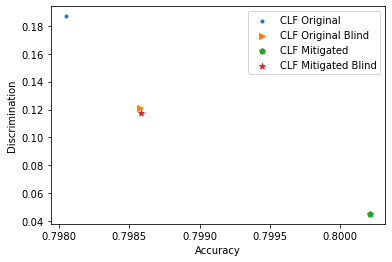

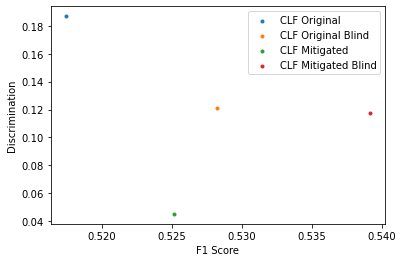

In [16]:
plotDisc(res)

In [17]:
FATInput=DataDescription(X_test,y_test,class_names,column_names,protected,protected_feature)

The grouping based on the *races* feature has the following distribution:
    * "('race_African-American',)" grouping has 956 instances.
    * "('race_Asian',)" grouping has 6 instances.
    * "('race_Caucasian',)" grouping has 628 instances.
    * "('race_Hispanic',)" grouping has 164 instances.
    * "('race_Native-American',)" grouping has 2 instances.
    * "('race_Other',)" grouping has 96 instances.

The class distribution per sub-population:
    * For the "('race_African-American',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 606 data points.
        - The class *High* has 350 data points.
    * For the "('race_Asian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 5 data points.
        - The class *High* has 1 data points.
    * For the "('race_Caucasian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 523 data points.
        - The class *High* has 105 

In [18]:
resDisparateImp=disparateImpactMetrics(clfs,FATInput,X_test,X_test_blind,y_test,protected_feature)
resDisparateImp

Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.


The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Native-American',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Native-American',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Native-American',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    * 

Some of the given labels are not present in either of the input arrays: {1}.


The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Native-American',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Native-American',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Native-American',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    * 

Some of the given labels are not present in either of the input arrays: {1}.


{'Equal Accuracy': {'Delta O-OB': ["'race_African-American' 'race_Other' "],
  'Delta M-MB': ["'race_African-American' 'race_Other' "],
  'Delta O-M': [],
  'Delta OB-MB': []},
 'Equal Opportunity': {'Delta O-OB': [],
  'Delta M-MB': [],
  'Delta O-M': [],
  'Delta OB-MB': []},
 'Demographic Parity': {'Delta O-OB': [],
  'Delta M-MB': [],
  'Delta O-M': [],
  'Delta OB-MB': []}}

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


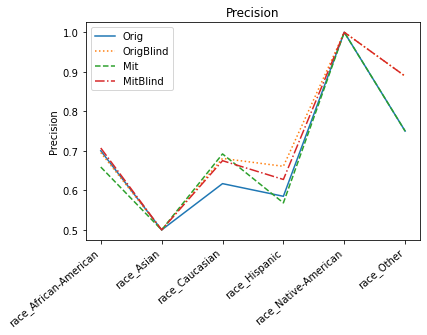

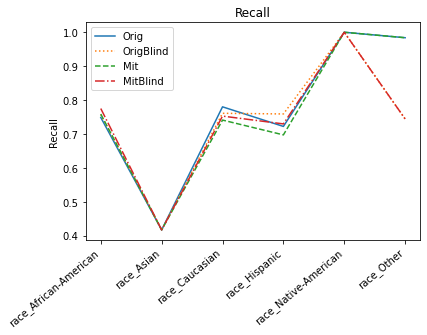

In [19]:
standardMetricsPerGroup(clfs,column_names,target,X_test,y_test,protected_feature,protected)

#### XAI Fixed Reference Set

In [ ]:
#To###

##### SHAP Kernel Explainer

In [20]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,14.657282,4.714294,15.001643,0.000000
SA-Mean,0.007951,0.002947,0.008087,0.000000
NSA-Sum,74.273217,75.312976,71.588227,78.072846
NSA-Mean,0.007024,0.009595,0.004462,0.006211


In [21]:
PIK = "US_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [22]:
PIK = "US_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)
shap_v

{'clfOrig':            age       sex  priors_count  days_b_screening_arrest  \
 0    -0.040900  0.000000      0.002054                 0.000000   
 1    -0.060652  0.000000      0.006743                 0.000047   
 2    -0.014024  0.000000      0.096388                 0.000000   
 3    -0.004293  0.000000      0.301912                 0.000000   
 4    -0.003553  0.000000     -0.000772                 0.000000   
 ...        ...       ...           ...                      ...   
 1847 -0.032116  0.000000      0.000000                -0.016738   
 1848 -0.081624 -0.010539      0.003027                 0.000000   
 1849  0.001271  0.000000      0.020700                 0.000000   
 1850 -0.056331  0.000000      0.023271                 0.000000   
 1851 -0.008669 -0.028046      0.000000                 0.000000   
 
       c_charge_degree  is_recid  is_violent_recid  two_year_recid  \
 0           -0.033263  0.038930          0.011814        0.040789   
 1           -0.004219  0.05519

In [23]:
resSHAP.to_csv(path_or_buf=path_res+'US_RF_ResSHAP_Fix.csv')
resSHAP = pd.read_csv(path_res+'US_RF_ResSHAP_Fix.csv',index_col=0)
resSHAP

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,14.657282,4.714294,15.001643,0.000000
SA-Mean,0.007951,0.002947,0.008087,0.000000
NSA-Sum,74.273217,75.312976,71.588227,78.072846
NSA-Mean,0.007024,0.009595,0.004462,0.006211


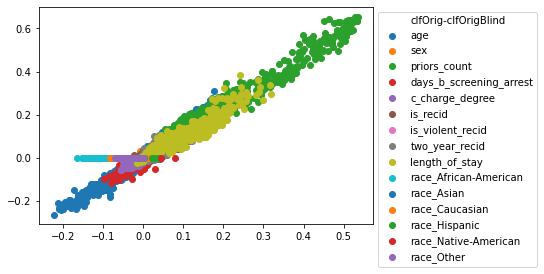

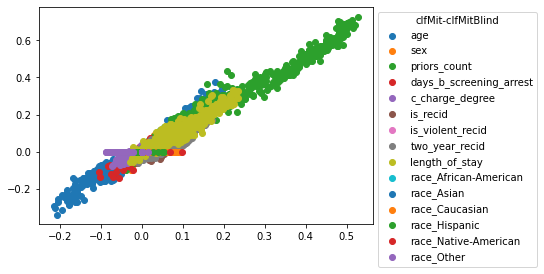

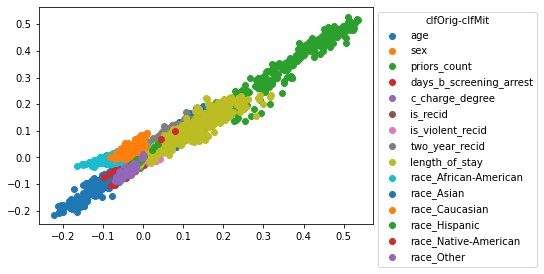

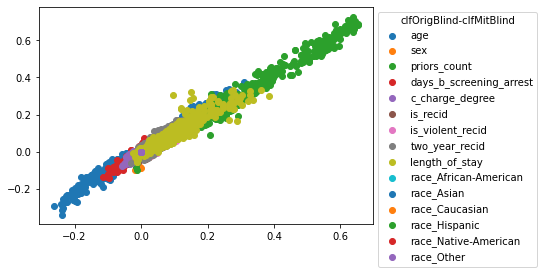

In [24]:
XAIPlots(shap_v,column_names,diffClfs=True)

##### SHAP Explainer 4 Trees

In [25]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=True)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,1.113150,0.807868,1.492700,0.000000
SA-Mean,0.011104,0.005370,0.012589,0.000000
NSA-Sum,4.161041,6.252311,5.140649,5.305467
NSA-Mean,0.007043,0.008886,0.004722,0.005800


In [26]:
PIK = "US_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [27]:
PIK = "US_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)
shap_v

{'clfOrig':            age       sex  priors_count  days_b_screening_arrest  \
 0    -0.078383  0.000424     -0.071757                 0.001446   
 1    -0.115933 -0.000186     -0.067541                 0.005803   
 2    -0.026718 -0.000386      0.011261                 0.006435   
 3     0.021678  0.002601      0.227676                 0.002387   
 4    -0.017415  0.004153     -0.052939                 0.003117   
 ...        ...       ...           ...                      ...   
 1847 -0.048491  0.000516     -0.048017                -0.004005   
 1848 -0.101438 -0.005015     -0.057493                 0.002247   
 1849 -0.008285 -0.000142     -0.041904                 0.001145   
 1850 -0.093753  0.001987     -0.013162                 0.001460   
 1851 -0.021064 -0.014164     -0.063140                 0.001979   
 
       c_charge_degree  is_recid  is_violent_recid  two_year_recid  \
 0           -0.030494  0.035783          0.023157        0.028403   
 1           -0.013554  0.04355

In [28]:
resSHAP.to_csv(path_or_buf=path_res+'US_RF_ResSHAP_Fix_Tree.csv')
resSHAP = pd.read_csv(path_res+'US_RF_ResSHAP_Fix_Tree.csv',index_col=0)
resSHAP

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,1.113150,0.807868,1.492700,0.000000
SA-Mean,0.011104,0.005370,0.012589,0.000000
NSA-Sum,4.161041,6.252311,5.140649,5.305467
NSA-Mean,0.007043,0.008886,0.004722,0.005800


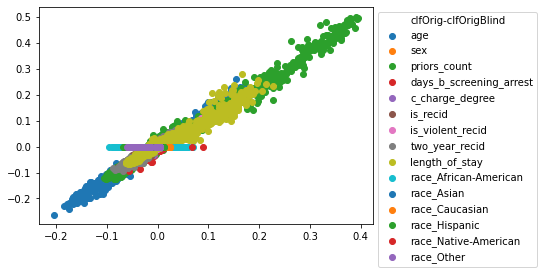

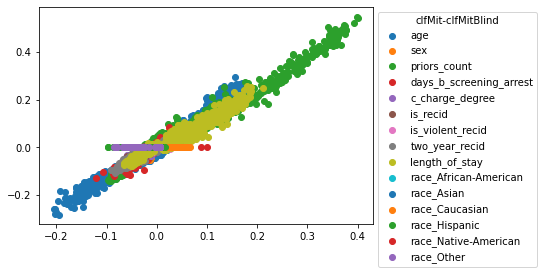

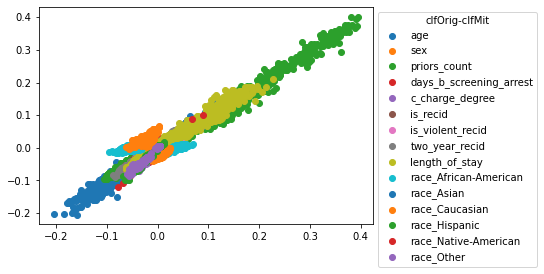

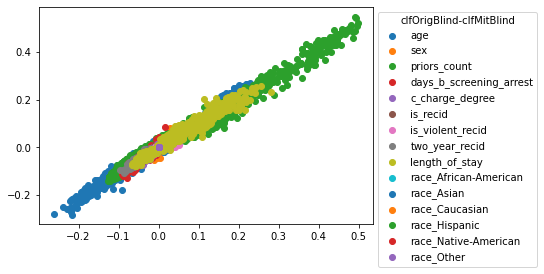

In [29]:
XAIPlots(shap_v,column_names,diffClfs=True)

##### LIME

In [30]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,38.395564,52.615200,85.520794,0.395004
SA-Mean,0.045322,0.040063,0.040042,0.021475
NSA-Sum,28.610862,24.482121,26.568106,26.524876
NSA-Mean,0.011582,0.014357,0.007980,0.007994


In [31]:
PIK = "US_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [32]:
PIK = "US_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)
lime_v

{'clfOrig':            age  sex  priors_count  days_b_screening_arrest  c_charge_degree  \
 0    -0.036893  0.0     -0.115666                 0.015017        -0.018185   
 1    -0.123812  0.0     -0.056508                -0.012709        -0.025178   
 2    -0.045699  0.0      0.277206                 0.026797        -0.030306   
 3    -0.043909  0.0      0.286143                 0.017468        -0.029073   
 4    -0.040475  0.0     -0.055967                 0.022152        -0.019235   
 ...        ...  ...           ...                      ...              ...   
 1847 -0.035057  0.0     -0.097359                 0.002831        -0.028980   
 1848 -0.120861  0.0     -0.120703                 0.019325         0.029067   
 1849  0.012637  0.0     -0.046860                 0.014227        -0.028829   
 1850 -0.119987  0.0     -0.059410                 0.021000         0.032291   
 1851 -0.025630  0.0     -0.092526                 0.016163        -0.022280   
 
       is_recid  is_violent

In [33]:
resLIME.to_csv(path_or_buf=path_res+'US_RF_ResLIME_Fix.csv')
resLIME = pd.read_csv(path_res+'US_RF_ResLIME_Fix.csv',index_col=0)
resLIME

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,38.395564,52.615200,85.520794,0.395004
SA-Mean,0.045322,0.040063,0.040042,0.021475
NSA-Sum,28.610862,24.482121,26.568106,26.524876
NSA-Mean,0.011582,0.014357,0.007980,0.007994


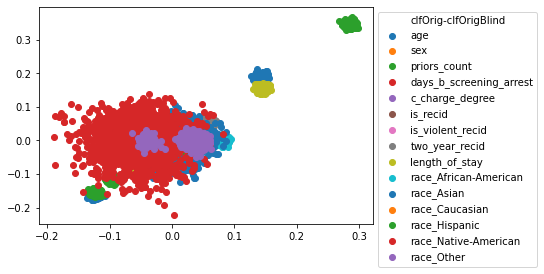

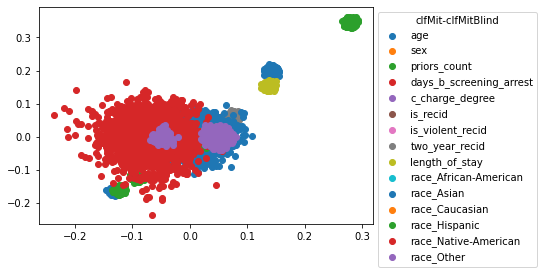

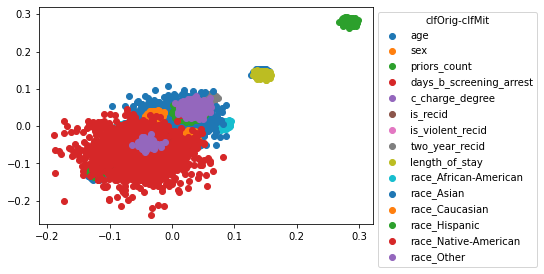

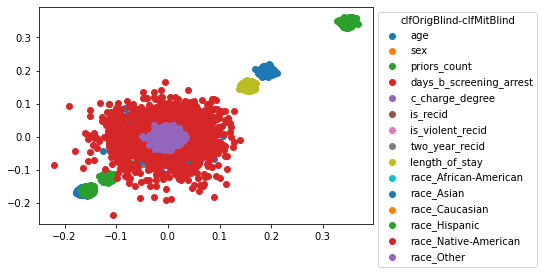

In [34]:
XAIPlots(lime_v,column_names,diffClfs=True)

#### XAI Changing Reference Set

##### SHAP Kernel Explainer

In [35]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,14.657282,4.714294,15.001643,0.000000
SA-Mean,0.007951,0.002947,0.008087,0.000000
NSA-Sum,74.273217,75.312976,71.588227,78.072846
NSA-Mean,0.007024,0.009595,0.004462,0.006211


In [36]:
PIK = "US_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [37]:
PIK = "US_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)
shap_v

{'clfOrig':            age       sex  priors_count  days_b_screening_arrest  \
 0    -0.040900  0.000000      0.002054                 0.000000   
 1    -0.060652  0.000000      0.006743                 0.000047   
 2    -0.014024  0.000000      0.096388                 0.000000   
 3    -0.004293  0.000000      0.301912                 0.000000   
 4    -0.003553  0.000000     -0.000772                 0.000000   
 ...        ...       ...           ...                      ...   
 1847 -0.032116  0.000000      0.000000                -0.016738   
 1848 -0.081624 -0.010539      0.003027                 0.000000   
 1849  0.001271  0.000000      0.020700                 0.000000   
 1850 -0.056331  0.000000      0.023271                 0.000000   
 1851 -0.008669 -0.028046      0.000000                 0.000000   
 
       c_charge_degree  is_recid  is_violent_recid  two_year_recid  \
 0           -0.033263  0.038930          0.011814        0.040789   
 1           -0.004219  0.05519

In [38]:
resSHAP.to_csv(path_or_buf=path_res+'US_RF_ResSHAP_Change.csv')
resSHAP = pd.read_csv(path_res+'US_RF_ResSHAP_Change.csv',index_col=0)
resSHAP

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,14.657282,4.714294,15.001643,0.000000
SA-Mean,0.007951,0.002947,0.008087,0.000000
NSA-Sum,74.273217,75.312976,71.588227,78.072846
NSA-Mean,0.007024,0.009595,0.004462,0.006211


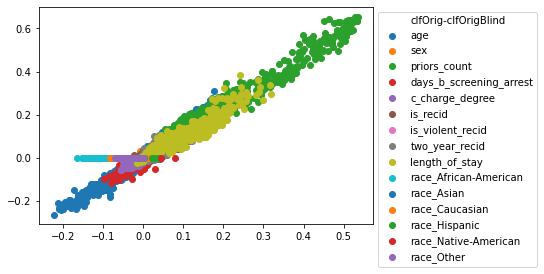

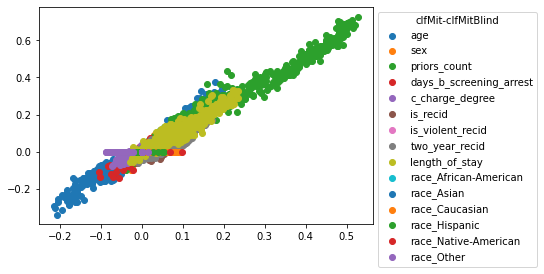

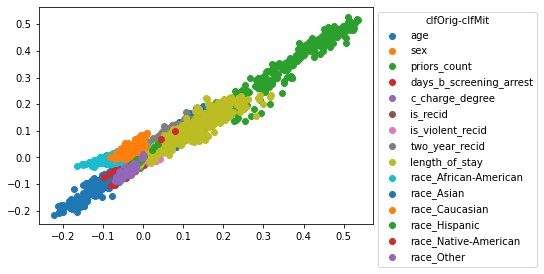

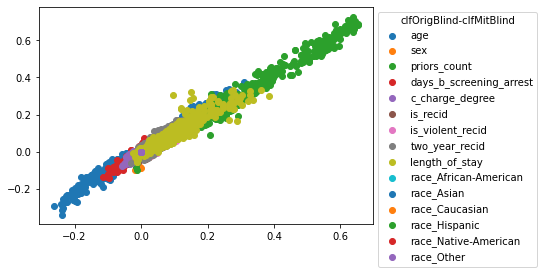

In [39]:
XAIPlots(shap_v,column_names,diffClfs=True)

##### SHAP Explainer 4 Trees

In [40]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=True)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,1.113150,0.807868,1.492700,0.000000
SA-Mean,0.011104,0.005370,0.012589,0.000000
NSA-Sum,4.161041,6.252311,5.140649,5.305467
NSA-Mean,0.007043,0.008886,0.004722,0.005800


In [41]:
PIK = "US_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [42]:
PIK = "US_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)
shap_v

{'clfOrig':            age       sex  priors_count  days_b_screening_arrest  \
 0    -0.078383  0.000424     -0.071757                 0.001446   
 1    -0.115933 -0.000186     -0.067541                 0.005803   
 2    -0.026718 -0.000386      0.011261                 0.006435   
 3     0.021678  0.002601      0.227676                 0.002387   
 4    -0.017415  0.004153     -0.052939                 0.003117   
 ...        ...       ...           ...                      ...   
 1847 -0.048491  0.000516     -0.048017                -0.004005   
 1848 -0.101438 -0.005015     -0.057493                 0.002247   
 1849 -0.008285 -0.000142     -0.041904                 0.001145   
 1850 -0.093753  0.001987     -0.013162                 0.001460   
 1851 -0.021064 -0.014164     -0.063140                 0.001979   
 
       c_charge_degree  is_recid  is_violent_recid  two_year_recid  \
 0           -0.030494  0.035783          0.023157        0.028403   
 1           -0.013554  0.04355

In [43]:
resSHAP.to_csv(path_or_buf=path_res+'US_RF_ResSHAP_Change_Tree.csv')
resSHAP = pd.read_csv(path_res+'US_RF_ResSHAP_Change_Tree.csv',index_col=0)
resSHAP

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,1.113150,0.807868,1.492700,0.000000
SA-Mean,0.011104,0.005370,0.012589,0.000000
NSA-Sum,4.161041,6.252311,5.140649,5.305467
NSA-Mean,0.007043,0.008886,0.004722,0.005800


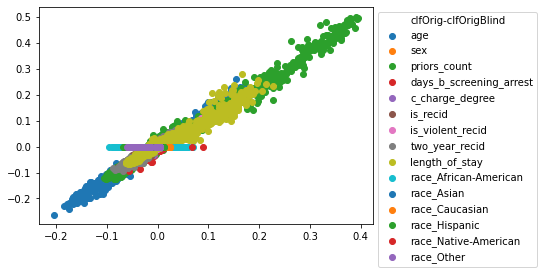

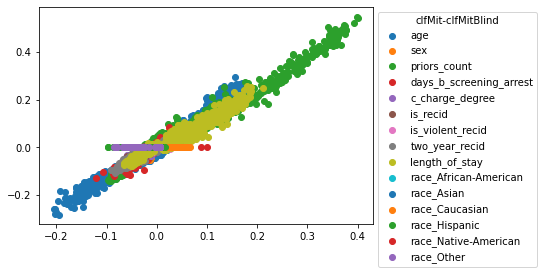

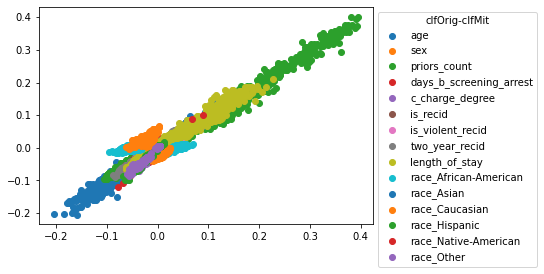

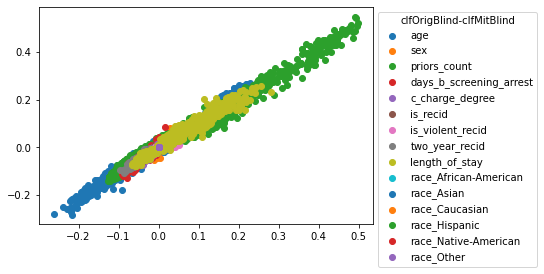

In [44]:
XAIPlots(shap_v,column_names,diffClfs=True)

##### LIME

In [45]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,38.651240,52.973019,85.962266,0.438436
SA-Mean,0.044701,0.039864,0.039963,0.020405
NSA-Sum,27.696741,23.664213,26.551430,24.809525
NSA-Mean,0.011131,0.014254,0.008003,0.007859


In [46]:
PIK = "US_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [47]:
PIK = "US_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)
lime_v

{'clfOrig':            age  sex  priors_count  days_b_screening_arrest  c_charge_degree  \
 0    -0.036893  0.0     -0.115666                 0.015017        -0.018185   
 1    -0.123812  0.0     -0.056508                -0.012709        -0.025178   
 2    -0.045699  0.0      0.277206                 0.026797        -0.030306   
 3    -0.043909  0.0      0.286143                 0.017468        -0.029073   
 4    -0.040475  0.0     -0.055967                 0.022152        -0.019235   
 ...        ...  ...           ...                      ...              ...   
 1847 -0.035057  0.0     -0.097359                 0.002831        -0.028980   
 1848 -0.120861  0.0     -0.120703                 0.019325         0.029067   
 1849  0.012637  0.0     -0.046860                 0.014227        -0.028829   
 1850 -0.119987  0.0     -0.059410                 0.021000         0.032291   
 1851 -0.025630  0.0     -0.092526                 0.016163        -0.022280   
 
       is_recid  is_violent

In [48]:
resLIME.to_csv(path_or_buf=path_res+'US_RF_ResLIME_Change.csv')
resLIME = pd.read_csv(path_res+'US_RF_ResLIME_Change.csv',index_col=0)
resLIME

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,38.651240,52.973019,85.962266,0.438436
SA-Mean,0.044701,0.039864,0.039963,0.020405
NSA-Sum,27.696741,23.664213,26.551430,24.809525
NSA-Mean,0.011131,0.014254,0.008003,0.007859


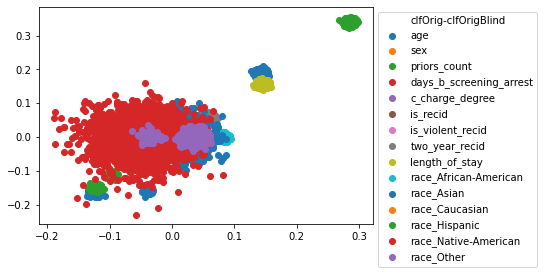

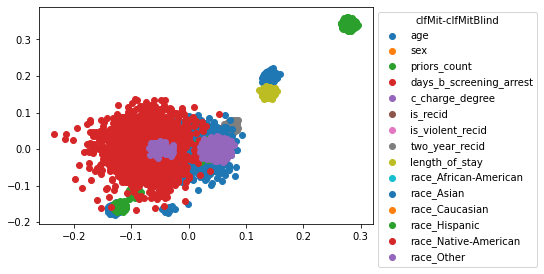

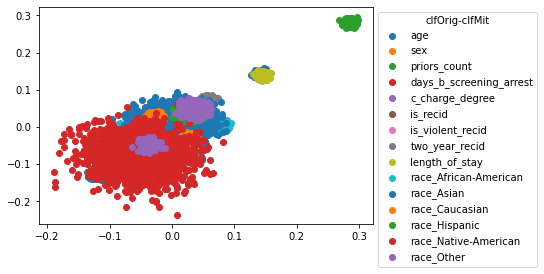

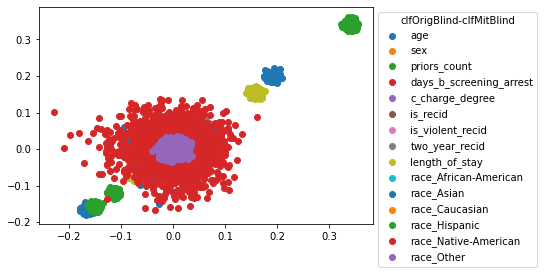

In [49]:
XAIPlots(lime_v,column_names,diffClfs=True)

## Preferential Sampling

In [ ]:
df = prepare_compass_dataset(filename, path_data, sensitive)
df

In [ ]:
target = 'target'
column_names = df.columns.values.tolist()
column_names.remove(target)
class_names=['Medium-Low','High']
adClass=0
disClass=1
protected = ['race_African-American','race_Asian','race_Caucasian','race_Hispanic','race_Native-American','race_Other']
protected_feature='races' 
non_sensitive = [elem for elem in column_names if elem not in protected]
adAttr='race_Caucasian'
disAttr='race_African-American'

In [ ]:
X,Y,X_blind,X_train,X_test,y_train,y_test,df=prepare_for_sampling(df,protected)

In [ ]:
findFreq(target,protected,df)

In [ ]:
#To###
ranker = rankers(X,X_blind,Y)

In [ ]:
#To###
PIK = "Ranker.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(ranker, f)

In [ ]:
PIK = "Ranker.dat"
with open(path_res+"/"+PIK, "rb") as f:
  ranker = pickle.load(f)

In [ ]:
df_new=PreferentialSampling(target,protected,ranker,df,adClass,disClass,adAttr,disAttr)

In [ ]:
findFreq(target,protected,df_new)

In [ ]:
X_train,X_train_blind,X_train_mod,X_train_mod_blind,y_train_mod,X_test,X_test_blind=prepare_for_classification(df_new,X_train,X_test,column_names,protected,False)

### MLP

In [ ]:
#To###
clf = MLPClassifier()
param_grid = dict(hidden_layer_sizes=[(50, 50, 50), (50, 100, 50)],
                          activation=['tanh', 'relu'],
                          solver=['sgd', 'adam'],
                          alpha=[0.0001, 0.05],
                          learning_rate=['constant', 'adaptive']
                          )

In [ ]:
#To###
clfOrig,clfOrigBlind,clfMit,clfMitBlind,res = Classifiers(clf,param_grid,target,column_names,X_train,X_train_mod,X_train_blind,X_train_mod_blind,y_train,y_train_mod,X_test,X_test_blind,y_test,protected,adClass,disClass,adAttr,disAttr)
res.to_csv(path_or_buf=path_res+'PS_MLP_Performances.csv')
res

In [ ]:
#To###
PIK = "PS_Clfs_MLP.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump([clfOrig,clfOrigBlind,clfMit,clfMitBlind], f)

In [ ]:
PIK = "PS_Clfs_MLP.dat"
with open(path_res+"/"+PIK, "rb") as f:
  clfOrig,clfOrigBlind,clfMit,clfMitBlind = pickle.load(f)
clfs={'clfOrig':clfOrig,'clfOrigBlind':clfOrigBlind,'clfMit':clfMit,'clfMitBlind':clfMitBlind}

In [ ]:
res = pd.read_csv(path_res+'PS_MLP_Performances.csv',index_col=0)
res

In [ ]:
plotDisc(res)

In [ ]:
FATInput=DataDescription(X_test,y_test,class_names,column_names,protected,protected_feature)

In [ ]:
resDisparateImp=disparateImpactMetrics(clfs,FATInput,X_test,X_test_blind,y_test,protected_feature)
resDisparateImp

In [ ]:
standardMetricsPerGroup(clfs,column_names,target,X_test,y_test,protected_feature,protected)

#### XAI Fixed Reference Set

In [ ]:
#To###

##### SHAP Kernel Explainer

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP

In [ ]:
PIK = "PS_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "PS_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)
shap_v

In [ ]:
resSHAP.to_csv(path_or_buf=path_res+'PS_MLP_ResSHAP_Fix.csv')
resSHAP = pd.read_csv(path_res+'PS_MLP_ResSHAP_Fix.csv',index_col=0)
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME

In [ ]:
PIK = "PS_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "PS_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)
lime_v

In [ ]:
resLIME.to_csv(path_or_buf=path_res+'PS_MLP_ResLIME_Fix.csv')
resLIME = pd.read_csv(path_res+'PS_MLP_ResLIME_Fix.csv',index_col=0)
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

#### XAI Changing Reference Set

##### SHAP Kernel Explainer

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP

In [ ]:
PIK = "PS_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "PS_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)
shap_v

In [ ]:
resSHAP.to_csv(path_or_buf=path_res+'PS_MLP_ResSHAP_Change.csv')
resSHAP = pd.read_csv(path_res+'PS_MLP_ResSHAP_Change.csv',index_col=0)
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME

In [ ]:
PIK = "PS_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "PS_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)
lime_v

In [ ]:
resLIME.to_csv(path_or_buf=path_res+'PS_MLP_ResLIME_Change.csv')
resLIME = pd.read_csv(path_res+'PS_MLP_ResLIME_Change.csv',index_col=0)
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

### RF

In [ ]:
#To###
clf = RandomForestClassifier()
param_grid = {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 'criterion' : ['gini', 'entropy'], 'bootstrap' : [True, False]}

In [ ]:
#To###
clfOrig,clfOrigBlind,clfMit,clfMitBlind,res = Classifiers(clf,param_grid,target,column_names,X_train,X_train_mod,X_train_blind,X_train_mod_blind,y_train,y_train_mod,X_test,X_test_blind,y_test,protected,adClass,disClass,adAttr,disAttr)
res.to_csv(path_or_buf=path_res+'PS_RF_Performances.csv')
res

In [ ]:
#To###
PIK = "PS_Clfs_RF.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump([clfOrig,clfOrigBlind,clfMit,clfMitBlind], f)

In [ ]:
PIK = "PS_Clfs_RF.dat"
with open(path_res+"/"+PIK, "rb") as f:
  clfOrig,clfOrigBlind,clfMit,clfMitBlind = pickle.load(f)
clfs={'clfOrig':clfOrig,'clfOrigBlind':clfOrigBlind,'clfMit':clfMit,'clfMitBlind':clfMitBlind}

In [ ]:
res = pd.read_csv(path_res+'PS_RF_Performances.csv',index_col=0)
res

In [ ]:
plotDisc(res)

In [ ]:
FATInput=DataDescription(X_test,y_test,class_names,column_names,protected,protected_feature)

In [ ]:
resDisparateImp=disparateImpactMetrics(clfs,FATInput,X_test,X_test_blind,y_test,protected_feature)
resDisparateImp

In [ ]:
standardMetricsPerGroup(clfs,column_names,target,X_test,y_test,protected_feature,protected)

#### XAI Fixed Reference Set

In [ ]:
#To###

##### SHAP Kernel Explainer

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP

In [ ]:
PIK = "PS_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "PS_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)
shap_v

In [ ]:
resSHAP.to_csv(path_or_buf=path_res+'PS_RF_ResSHAP_Fix.csv')
resSHAP = pd.read_csv(path_res+'PS_RF_ResSHAP_Fix.csv',index_col=0)
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

##### SHAP Explainer 4 Trees

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=True)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP

In [ ]:
PIK = "PS_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "PS_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)
shap_v

In [ ]:
resSHAP.to_csv(path_or_buf=path_res+'PS_RF_ResSHAP_Fix_Tree.csv')
resSHAP = pd.read_csv(path_res+'PS_RF_ResSHAP_Fix_Tree.csv',index_col=0)
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME

In [ ]:
PIK = "PS_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "PS_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)
lime_v

In [ ]:
resLIME.to_csv(path_or_buf=path_res+'PS_RF_ResLIME_Fix.csv')
resLIME = pd.read_csv(path_res+'PS_RF_ResLIME_Fix.csv',index_col=0)
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

#### XAI Changing Reference Set

##### SHAP Kernel Explainer

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP

In [ ]:
PIK = "PS_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "PS_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)
shap_v

In [ ]:
resSHAP.to_csv(path_or_buf=path_res+'PS_RF_ResSHAP_Change.csv')
resSHAP = pd.read_csv(path_res+'PS_RF_ResSHAP_Change.csv',index_col=0)
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

##### SHAP Explainer 4 Trees

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=True)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP

In [ ]:
PIK = "PS_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "PS_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)
shap_v

In [ ]:
resSHAP.to_csv(path_or_buf=path_res+'PS_RF_ResSHAP_Change_Tree.csv')
resSHAP = pd.read_csv(path_res+'PS_RF_ResSHAP_Change_Tree.csv',index_col=0)
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME

In [ ]:
PIK = "PS_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "PS_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)
lime_v

In [ ]:
resLIME.to_csv(path_or_buf=path_res+'PS_RF_ResLIME_Change.csv')
resLIME = pd.read_csv(path_res+'PS_RF_ResLIME_Change.csv',index_col=0)
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)